# Breast Cancer Project

## Project Setup

In [1]:
# import libraries required for the project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# for displaying matplotlib graphs
%matplotlib inline

# registers pandas formatters and converters with matplotlib
pd.plotting.register_matplotlib_converters()

# set maximum rows to be displayed to 5 rows
pd.set_option('display.max_rows', 5)

## Data Preparation

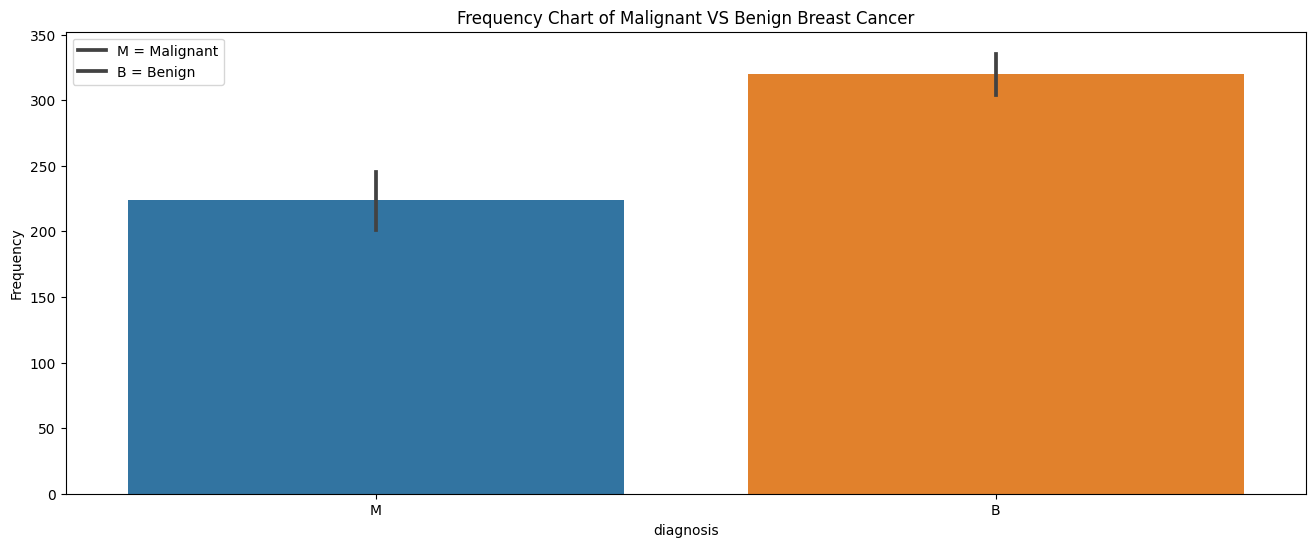

In [11]:
# let's plot a chart to see this pictorially
plt.figure(figsize=(16, 6))
# set the title
plt.title("Frequency Chart of Malignant VS Benign Breast Cancer")
# add label for vertical axis
plt.ylabel('Frequency')
# plot the chart using seaborn
sns.barplot(x=breast_cancer_data['diagnosis'], y = breast_cancer_data.index)
# add legend
plt.legend(labels=["M = Malignant", "B = Benign"])
# save the chart
plt.savefig('../../final_project/images/malignant_vs_benign_cancer.jpg')

# The Model(s)

### Preprocessing Step

In [12]:
# Separate target from predictors
y = breast_cancer_data.diagnosis      # target column
X = breast_cancer_data.drop(['diagnosis'], axis=1) # features

# divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y,
                                    train_size=0.8, test_size=0.2, random_state=98)

# Cardinality means the number of unique values in a column

# Select categorical columns with relatively low cardinality
categorical_cols = [cname for cname in X_train_full.columns
                    if X_train_full[cname].nunique() < 15
                    and X_train_full[cname].dtype == 'object']

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns
                  if X_train_full[cname].dtype in ['int64', 'float64']]

# let's keep only numerical and categorical columns
cols = categorical_cols + numerical_cols
X_train = X_train_full[cols].copy()
X_valid = X_valid_full[cols].copy()

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data 
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                         ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])
# bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

## Create and Evaluate the Pipeline

In [13]:
# Next we use the Pipeline class to define a pipeline that bundles the preprocessing and modelling steps
  ## Note:
# 1) With the pipeline, we preprocess the training data and fit the model in a single line of code.
    # In contrast, without a pipeline, we have to do imputation, one-hot encoding, and model training 
    # in separate steps.
    # This becomes especially messy if we have to deal with both numerical and categorical variables
# 2) With the pipeline, we supply the unprocessed features in X_valid to the predict() command, and the 
    # pipeline automatically preprocesses the features before generating predictions.
    # However, without a pipeline, we have to remember to preprocess the validation data
    # before making predictions

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

## RandomForest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

# model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
# Bundle preprocessing and modelling code in a pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', rf_classifier)])

# Preprocessing of training data
# Fit the RandomForestClassifier model
rf_pipeline.fit(X_train, y_train)

# Get predictions
rf_predictions = rf_pipeline.predict(X_valid)

# Evaluate RandomForest Model
rf_score = metrics.accuracy_score(y_valid, rf_predictions)
print('Accuracy score using RandomForestClassifier:', rf_score)
print(metrics.classification_report(y_valid, rf_pipeline.predict(X_valid)))

# RandomForestClassifier Accuracy = 95.5%

Accuracy score using RandomForestClassifier: 0.956140350877193
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



# XGBoostClassifier

In [15]:
from xgboost import XGBClassifier

# model
xgb_classifier = XGBClassifier(n_estimators=500, learning_rate=0.05)
# Bundle preprocessing and modelling code in a pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', xgb_classifier)])

# Preprocessing of training data
# Fit the RandomForestClassifier model
xgb_pipeline.fit(X_train, y_train)

# Get predictions
xgb_predictions = xgb_pipeline.predict(X_valid)

# Evaluate RandomForest Model
xgb_score = metrics.accuracy_score(y_valid, xgb_predictions)
print('Accuracy score using XGBoostClassifier:', xgb_score)
print(metrics.classification_report(y_valid, xgb_pipeline.predict(X_valid)))


Accuracy score using XGBoostClassifier: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



# Support Vector Classifier (SVC)

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# model
svc_pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto', shrinking=True))

svc_pipeline.fit(X_train, y_train)

#  Get predictions
svc_predictions = svc_pipeline.predict(X_valid)

# Evaluate SVC Model
svc_score = metrics.accuracy_score(y_valid, svc_predictions)
print('Accuracy score using SVC:', svc_score)
print(metrics.classification_report(y_valid, svc_pipeline.predict(X_valid)))

Accuracy score using SVC: 0.9649122807017544
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        72
           1       0.95      0.95      0.95        42

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



## Using Cross-Validation for Better Model Validation

In [30]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, shuffle=True,
              random_state=98)
xgb_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=kfold)
print("Mean Accuracy Score for XGBoostClassifier Using Cross Validation:\n", xgb_scores.mean())

# 

Mean Accuracy Score for XGBoostClassifier Using Cross Validation:
 0.9626086956521739
